# Pneumonia Detection using X-Ray Images
<font size = 5> Hazem Mohamed Abdelghafar 211001615</font>


<font size = 8>What is Pneumonia?</font> <br><br>
<font size = 3><b> Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli. Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty in breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases. Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis. The disease may be classified by where it was acquired, such as community, hospital-acquired or healthcare-associated pneumonia.</b></font>

## Library imports 

In [1]:
%load_ext chime

import os
import chime
import random
import cv2
import numpy as np
import pandas as pd
from PIL import Image 
from time import sleep
import matplotlib.pyplot as plt
from sklearn.utils import shuffle


from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization

from sklearn.metrics import classification_report, confusion_matrix


In [2]:
chime.theme('zelda')
chime.notify_exceptions()

## Data Preprocessing

### Loading the Dataset

In section I will load the images of the dataset into a dataframe while normalizing the images to range from 0 to 1 instead of ranging from 0 to 255. The images are also resized to 500x500 pixels to reduce the computational complexity of the model. The images are then shuffled to ensure that the training and testing sets are representative of the dataset.


In [3]:
train_path = os.path.join(os.getcwd(), 'input\\train')

test_path = os.path.join(os.getcwd(), 'input\\test')

val_path = os.path.join(os.getcwd(), 'input\\val')

training_set = [train_path, test_path, val_path]

labels = ['NORMAL', 'PNEUMONIA'] # 0 = Normal, 1 = Pneumonia

img_size = 500 # Number of pixels in each dimension

train_data = []
test_data = []
val_data = []

In [4]:
for x, data_dir in enumerate(training_set):
    for label in labels: 
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) # Loading the images
            if img_arr is None:
                continue
            resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
            norm_image = cv2.normalize(resized_arr, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) # Normalizing the images from range [0,1]
            if x == 0:
                train_data.append([norm_image, label]) # Adding image array and label to the train_data list
            elif x == 1:
                test_data.append([norm_image, label]) # Adding image array and label to the test_data list
            elif x == 2:
                val_data.append([norm_image, label]) # Adding image array and label to the val_data list


In [5]:
train_df = pd.DataFrame(train_data, columns=['Image Matrix', 'Label'])
test_df = pd.DataFrame(test_data, columns=['Image Matrix', 'Label'])
val_df = pd.DataFrame(val_data, columns=['Image Matrix', 'Label'])

In [6]:
# Normal labeled images are loaded first, then Pneumonia labeled images are loaded second
# Therefore, we need to shuffle the dataframes to avoid bias

train_df = shuffle(train_df)
test_df = shuffle(test_df)
val_df = shuffle(val_df)

In [7]:
train_df.sample(5)

,Image Matrix,Label
6241,"[[0.114173226, 0.114173226, 0.114173226, 0.106...",PNEUMONIA
5496,"[[0.023529414, 0.027450982, 0.03137255, 0.0313...",PNEUMONIA
5013,"[[0.098039225, 0.098039225, 0.098039225, 0.098...",PNEUMONIA
6801,"[[0.03529412, 0.03529412, 0.03529412, 0.035294...",PNEUMONIA
7119,"[[0.30588236, 0.29411766, 0.28235295, 0.282352...",PNEUMONIA


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7720 entries, 1116 to 4960
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Image Matrix  7720 non-null   object
 1   Label         7720 non-null   object
dtypes: object(2)
memory usage: 180.9+ KB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 624 entries, 590 to 100
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Image Matrix  624 non-null    object
 1   Label         624 non-null    object
dtypes: object(2)
memory usage: 14.6+ KB


In [10]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, 0 to 2
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Image Matrix  16 non-null     object
 1   Label         16 non-null     object
dtypes: object(2)
memory usage: 384.0+ bytes


### Data Augmentation

The train dataset had a total of 5216 image, 1341 of which were Normal cases and 3875 were Pneumonia cases. This is a very unbalanced dataset, so we will use data augmentation to increase the number of images in the dataset to prevent any overfitting that might occur.

I used the ImageDataGenerator class from the keras library to augment the images. The augmentation techniques used were rotation, width shift, height shift, zoom, and shear. The augmented images were then saved to a new directory and then appended to the original dataset. The new dataset had a total of 7720 images, 3845 of which were Normal cases and 3875 were Pneumonia cases.


<font size = 6><a href="./image_generator.ipynb"> Click me to open Data Augmentation notebook</a></font>

## Data Visualization

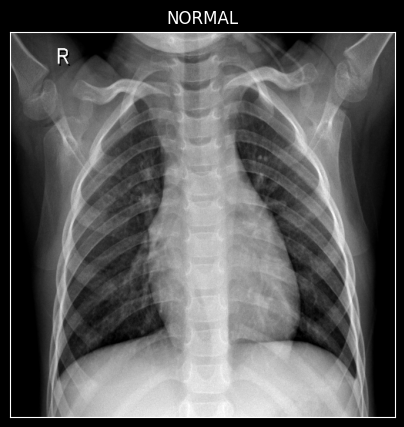

In [11]:
# Image example of the dataset
rand_num = random.randint(0, 5215)
plt.figure(figsize = (5,5))
plt.imshow(train_df['Image Matrix'][rand_num], cmap='gray')
plt.title(train_df['Label'][rand_num])
plt.xticks([])
plt.yticks([])
plt.show()

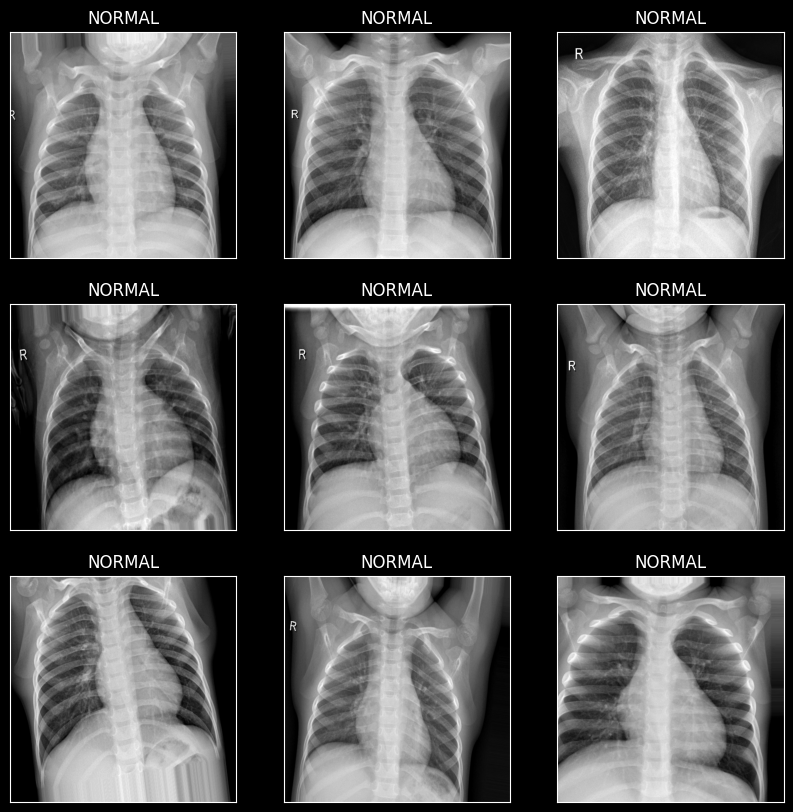

In [12]:
# visualize the data
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_df['Image Matrix'][i], cmap='gray')
    plt.title(train_df['Label'][i])
    plt.xticks([])
    plt.yticks([])
plt.show()


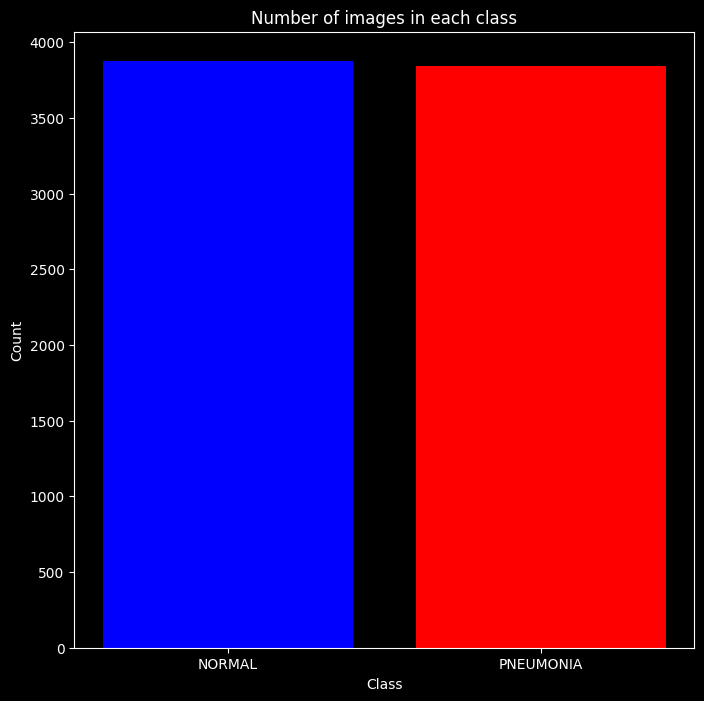

In [13]:
# visualize the number of images in each class
plt.figure(figsize=(8, 8))
plt.bar(train_df['Label'].unique(), train_df['Label'].value_counts(), color=['blue', 'red'])
plt.title('Number of images in each class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


## Neural Network Architecture

### Building the CNN Model

In [14]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (500,500,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [15]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 500, 500, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 500, 500, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 250, 250, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 64)      18496     
                                                                 
 dropout (Dropout)           (None, 250, 250, 64)      0         
                                                                 
 batch_normalization_1 (Bat  (None, 250, 250, 64)      2

In [16]:
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)


In [18]:
# Convert labels to numeric values
train_df['Label'] = train_df['Label'].map({'NORMAL': 0, 'PNEUMONIA': 1})
val_df['Label'] = val_df['Label'].map({'NORMAL': 0, 'PNEUMONIA': 1})

# Train the model
history = model.fit(x=np.array(train_df['Image Matrix'].tolist()), y=train_df['Label'], epochs=7, validation_data=(np.array(val_df['Image Matrix'].tolist()), val_df['Label']), callbacks=[learning_rate_reduction], verbose=1)


Epoch 1/12
242/242 [==============================] - 1098s 4s/step - loss: 1.8024 - accuracy: 0.8714 - val_loss: 18.3463 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
242/242 [==============================] - 1315s 5s/step - loss: 0.1980 - accuracy: 0.9455 - val_loss: 8.9926 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
242/242 [==============================] - 1004s 4s/step - loss: 0.1255 - accuracy: 0.9631 - val_loss: 0.6612 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/12
242/242 [==============================] - 3644s 15s/step - loss: 0.1044 - accuracy: 0.9710 - val_loss: 0.7278 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/12
242/242 [==============================] - ETA: 0s - loss: 0.0867 - accuracy: 0.9734
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
242/242 [==============================] - 1017s 4s/step - loss: 0.0867 - accuracy: 0.9734 - val_loss: 3.2088 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 6/12
242/242 [==============================] 